# Conversion from deconvolved signal to origin
### Author: Javier Gamero Muñoz

# General libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# Load data

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

## Ideal data (origin)

In [3]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t_id = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t_id.set_index(0, inplace=True)

t_id = np.array(t_id).reshape(-1).astype(np.int32)
print(t_id.shape)

(1000,)


In [4]:
id_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
signals_id = pd.read_csv(id_path, sep=';', header=None)
signals_id.set_index(0, inplace=True)
print('Ideal signals df shape: ', signals_id.shape)

Ideal signals df shape:  (9325, 1000)


## Deconvolved data

In [5]:
t_path = os.path.join(PATH, 'data_preproc/DeconvolvedSignal_t.csv')
t_dec = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t_dec.set_index(0, inplace=True)

t_dec = np.array(t_dec).reshape(-1).astype(np.int32)
t_dec.shape

(5050,)

In [6]:
m0 = time()
dec_path = os.path.join(PATH, 'data_preproc/DeconvolvedSignal2.csv') # right indexes
signals_dec = pd.read_csv(dec_path, sep=',', header=0, index_col=0)

print('Time spent reading dec signals: ', time()-m0)
print('Dec signals df shape: ', signals_dec.shape)

Time spent reading dec signals:  4.3475987911224365
Dec signals df shape:  (9325, 5050)


# Processing data

In [7]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
# this function will plot the loss results of NN training. It should be used 
# to check if the NN is oferfitting 
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

As it can easily be seen, the deconvolved data has more timesteps although 
it represent the same time series than the original.  
This is why we will undersample all this time series. 

We create a function that calculates the average value of the time serie in a 
window of time `[t-timestep:t+timestep]` where timestep is defined as: 
$$
timestep=t_i - t_{i+1}.
$$
Notice tha $t_j$ makes allusion to the moment $j$ of the ideal time serie.

In [8]:
def underSample_avg(t_little, t_big, signal): 
    """
    Function to undersampler data
    Parameters: 
        - t_little: array with number timesteps to achieve
        - t_big: actual array with timesteps of the signal
        - signal: signal to be undersampled
    """
    
    signal = np.array(signal)
    timestep = t_little[1]-t_little[0]
    signal_us = []
    
    for idx in range(len(t_little)): 
        t = t_little[idx]
        
        # environment to calculate the average value
        window = np.argwhere((t_big>=t-timestep) & 
                             (t_big<=t+timestep)).reshape(-1)
        
        signal_us.append(np.mean(signal[window]))
        
    return np.array(signal_us).reshape(-1)

We test the function: 

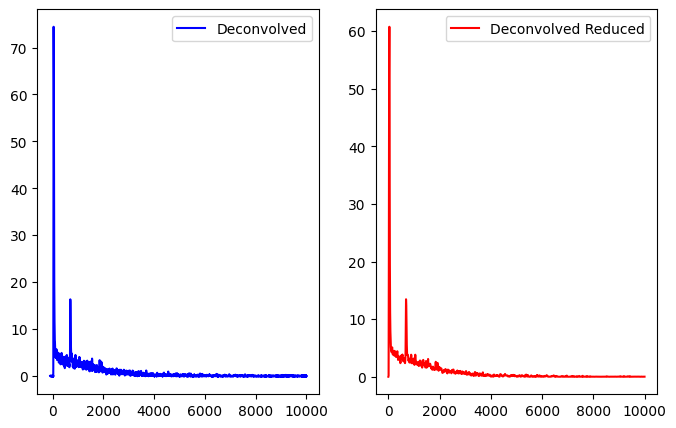

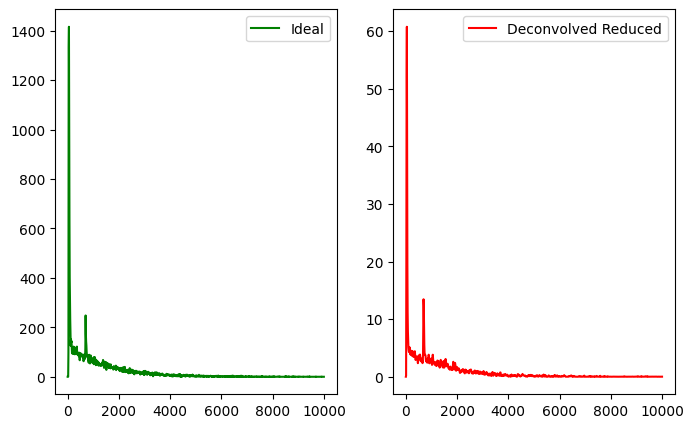

In [12]:
i=10
signal_us = underSample_avg(t_id, t_dec, signals_dec.iloc[i,:])
signal_us.shape

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_dec, signals_dec.iloc[i,:], label='Deconvolved', c='b')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signal_us, label='Deconvolved Reduced', c='r')
plt.legend()

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_id, signals_id.iloc[i,:], label='Ideal', c='g')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signal_us, label='Deconvolved Reduced', c='r')
plt.legend()


Now we apply it to all the series that accomplish all the criterias.  
Hence, we remove those time series that do not: 

In [ ]:
t0 = 150 #(ns), moment after we let the electron appear
peak=5 # necessary min of n_photons of the peak of the electron time serie